In [215]:
# paramètres : je les ai réunis ici afin d'avoir un code 'modulaire' : on peut choisir ce qu'on veut
# observer en fonction de paramètres listés ici

# pour le choix du matériau
cle_materiau = "mp-20072"

# propre à l'utilisateur
cle_utilisateur = "om6hvHlirPcyuxXF"

# le nombre de décimales qu'on veut voir pour les valeurs chiffrées
dec = 4

In [216]:
# téléchargement

from pymatgen.ext.matproj import MPRester
import pymatgen.electronic_structure.core as elstruct
from pymatgen.electronic_structure import plotter
from matplotlib import pyplot as plt
import numpy as np

with MPRester(cle_utilisateur) as m:
    band = m.get_bandstructure_by_material_id(cle_materiau)
    plot = plotter.BSPlotter(band)

In [217]:
# on récupère la bande interdite et on imprime ses attributs
band_gap = band.get_band_gap()
print('La bande interdite est directe ?     : '+str(band_gap['direct']))
print('L\'énergie de la bande interdite est  : '+str(round(band_gap['energy'],dec))+' [eV]')
print('transition de la bande interdite     : '+band_gap['transition']+'\n')

La bande interdite est directe ?     : False
L'énergie de la bande interdite est  : 2.5162 [eV]
transition de la bande interdite     : Z-L



Ci dessus se trouvent les caractéristiques de la bande interdite. On peut en dire que si le matériau n'est pas isolant, il faudra un apport d'énergie notable pour augmenter sa conductivité.

Si un électron franchit la bande interdite, il passera d'un vecteur d'onde $Z$ à un vecteur d'onde $L$.

In [218]:
# on prépare les données pour la suite des calculs

hbar = 6.582119570e-16

# on recupere et prépare les donnees pour les premieres et dernieres bandes de conduction et valence
cv_bands = [band.get_cbm(), band.get_vbm()]
names = ['première bande de conduction', 'dernière bande de valence']
descriptif_m_ef = ['à la base de', 'au sommet de']
names_to_get_the_data = ['cbm', 'vbm']
colors = ['r','g']

list = zip(cv_bands, names, names_to_get_the_data, colors, descriptif_m_ef)

# petit helper pour calculer la pente entre 2 points
pente = lambda x,y : abs((y[-1]-y[0])/(x[-1]-x[0]))

# petit helper pour retourner x[0],y[0],x[-1]-x[0],y[-1]-y[0] (sera utilisé pour tracer les fleches plus loin)
coord = lambda x,y,index : [ x[0], y[index][0], x[-1]-x[0], y[index][-1]-y[index][0]]

# on cree la clé utile à recuperer les bandes de frequence
cle = elstruct.Spin(1)

# on récupère les axes x et y selon lesquels sont plottées les bandes et d'autres données utiles au plot 
donnees_plot = plot.bs_plot_data()
x = donnees_plot.get('distances')
y = [ yi.get('1') for yi in donnees_plot.get('energy')]
ticks = donnees_plot.get('ticks').get('distance')
nb_ticks = len(x)

In [219]:
# petite fonction utilitaire avec exemple

def get_indexes(a, n=1,maxi=True):
    """
    Donne dans un tableau les indices des 'n' premiers maximums du tableau 'a' sans le modifier.
    Par défaut, la fonction renvoie le maximum du tableau (n = 1) (sans le mettre dans un tableau)
    
    Si max est mis à 'False', la fonction ne cherche plus les indices des maximums
    mais ceux des minimums
    """
    index = [-1]*n
    if maxi:
        init_value = min(a)
        condition = lambda a,b : a > b
    else:
        init_value = max(a)
        condition = lambda a,b : a < b
    
    for i in range(n):
        max_min = init_value
        index_i = -1
        for j in range(len(a)):
            if condition(a[j],max_min)  and j not in index:
                max_min = a[j]
                index_i = j
        index[i] = index_i
    
    if n == 1 :
        return index[0]
    else :
        return index
    
# exemple
    
print('exemples d\'utilisation :\n')
a = [0,500,8,-5,12]
print('si a = '+str(a)+' et n = 2,')
print('le résultat est : '+str(get_indexes(a,2)))
print('ce qui donne bien les indices des 2 plus grandes valeurs du tableau')
print('\nsi on fait l\'opération avec max à False, on a : '+str(get_indexes(a,2,False)))
print('ce qui donne bien les indices des 2 plus petites valeurs du tableau')

exemples d'utilisation :

si a = [0, 500, 8, -5, 12] et n = 2,
le résultat est : [1, 4]
ce qui donne bien les indices des 2 plus grandes valeurs du tableau

si on fait l'opération avec max à False, on a : [3, 0]
ce qui donne bien les indices des 2 plus petites valeurs du tableau



bande(s) correspondant à la première bande de conduction : 
20 
énergie  : 6.5501 eV

Masse effective à la base de la première bande de conduction = 8.267869580956204e-33 [kg]

bande(s) correspondant à la dernière bande de valence : 
18 19 
énergie  : 4.0339 eV

Masse effective au sommet de la dernière bande de valence = 4.0275197111148927e-32 [kg]


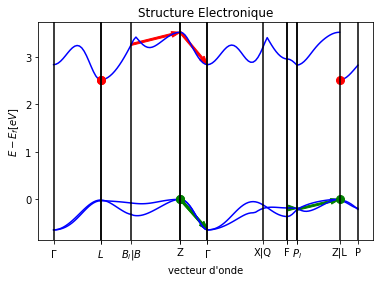

In [220]:
# on imprime les données pour chaque bande avec également un joli plot

fig, ax = plt.subplots()

for info_bm,name,cvbm,col,desc in list:
    
    energie = info_bm['energy']
    index_bandes = info_bm['band_index'][cle]
    len_index = len(index_bandes)
    print('\nbande(s) correspondant à la '+name+' : ')
    
    # il faut maintenant chercher les max et min de dispersion pour chaque bande : 
    # les pentes max et min pour les bandes concernées
    pente_bande = [0]*nb_ticks
    for index in index_bandes:
        print(index, end=' ')
        for i in range(nb_ticks):
            yi = y[i][index]
            xi = x[i]
            pente_bande[i] = pente(xi, yi)
            plt.plot(xi, yi,'b')
        
        # un tableau dans lequel on a les index des minimum et maximum de la bande de dispersion
        index_m = [get_indexes(pente_bande), get_indexes(pente_bande,maxi = False)]
        
        # on récupère les coordonnées de début et fin de la zone dans laquelle se trouvent le max
        # et le min de dispersion et on trace une jolie fleche
        for im in index_m:
            pts = coord(x[im], y[im], index)
            plt.arrow(pts[0],pts[1],pts[2],pts[3],color=col,width=.04,length_includes_head=True)
    
    print('\nénergie  : '+str(energie)+' eV')
        
    # partie où l'on s'occupe du calcul de la masse effective
    norm_k = np.linalg.norm(info_bm['kpoint'].frac_coords)
    m_effective = hbar**2*norm_k**2/(2*energie)
    print('\nMasse effective '+desc+' la '+name+' = '+str(m_effective)+' [kg]')
    
    # on imprime les points marquants les min ou max de la bande en question
    # cela aura pour effet de nous montrer le band_gap trouvé plus haut ainsi que le direct_band_gap()
    for xi,yi in donnees_plot.get(cvbm):
        plt.plot(xi,yi,'o'+col,markersize=8)
    
for xi in ticks:
    plt.axvline(xi,0,color='black')   
plt.xlabel('vecteur d\'onde')
plt.ylabel('$ E - E_f [eV] $')
plt.title('Structure Electronique')
ax.set_xticks(ticks)
ax.set_xticklabels(['$\Gamma$', '$L$ ', '', '$B_l | B$', 'Z', '', '$\Gamma$', '', 'X|Q', 'F', '', '$P_l$', '', 'Z|L', 'P'])
plt.show()

Et voici le plot montrant les bandes de valence concernées, avec les flèches indiquant les maximum et minimum de
dispersion de ces bandes.

Sur le graphe, en plus des 2 points concernant le band_gap() mentionné plus haut, on observe pour le vecteur d'onde $Z|L$, le direct_band_gap(). Celui-ci a une énergie légèrement plus grande que le band_gap() mais n'effectue pas de transition. 

Les flèches ayant la plus grande pente représentent les maximums de dispersion, celles ayant la plus petite pente représentent les minimums de dispersion.

Pour le calcul de la masse effective, j'ai utilisé la formule suivante : 
$
\begin{equation}
    m* = \frac{\hbar^2 \cdot ||k||^2}{2 (\epsilon(k_p) - \epsilon_0)}
\end{equation}
$
en considérant que $\epsilon(k_p) - \epsilon_0$ est l'énergie au point maximum ou minimum de bande. Avec $k_p$ le vecteur d'onde correspondant.

En effet, l'on a que 
$
\begin{equation}
    \epsilon(k) = \epsilon_0 \pm \frac{\hbar^2 \cdot ||k||^2}{2m*}
\end{equation}
$
comme on s'intéresse à des états voisins d'un minimum ou maximum de bande.
   
   
### Références

1.	‘adam-p/markdown-here’, GitHub. https://github.com/adam-p/markdown-here (accessed Apr. 01, 2020).
2.	‘Cours : LMAPR1492 - Physique des Matériaux’. https://moodleucl.uclouvain.be/course/view.php?id=7353 (accessed Apr. 03, 2020).
3.	‘Théorie des bandes’, Wikipédia. Dec. 13, 2019, Accessed: Apr. 01, 2020. [Online]. Available: 
4.	K. Persson, ‘Materials Data on LaCuO2 (SG:166) by Materials Project’. LBNL Materials Project; Lawrence Berkeley National Laboratory (LBNL), Berkeley, CA (United States), 2014, doi: 10.17188/1195228.
    